In this notebook, I compare the coupling values for T6/PDI dimers obtained from POD calculations and X-SH. I read in coupling values from external files and plot them against eachother. I am looking for a linear relationship between POD coupling and X-SH overlap since we assert that they follow the relationship H = CS for our AOM method. Therefore, we expect a linear correlation that can be reasonably fit with the universal scaling constant of 9659 meV.

I ran a 10ps X-SH simulation and then extracted T6-T6 and PDI-PDI dimer geometries every 0.1 ps for a total of 100 dimer configurations each, alongside these dimers' corresponding coupling values obtained from the run-pseudo-hamilt.xyz file. I used these geometries to caclulate the POD coupling in archer2, and the pyAOM overlap, which we can then compare.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
from scipy.optimize import curve_fit

In [17]:
def read_coupling_file(file_path):

    '''
    function that reads values from file into 1D array, each line in the file must have only 1 object for this 
    to work
    '''

    with open(file_path) as full_file:
        coupling_list = full_file.readlines()

        couplings = map(float, coupling_list)
        couplings = list(couplings)

        coupling_array = np.array(couplings)

    return coupling_array

In [18]:
def h_sc(constant, overlaps):

    return constant*overlaps

In [19]:
XSH_T6_array = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/T6_dimer_XSH_couplings.xyz')
#reading in T6-T6 coupling file from X-SH

XSH_T6_array = abs(XSH_T6_array)*27211 #converting couplings from Hartree to meV

T6_POD_array = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/T6_dimer_POD_couplings_1ps.txt')
T6_POD_array = abs(T6_POD_array)*1.325
#reading in T6-T6 POD couplings then multiplying them all by scaling constant used in Fruszina's paper

scaling_constant = 0.347759*27211 #this scaling constant is the C in H = CS, converted now to meV

XSH_T6_array = XSH_T6_array/scaling_constant #getting overlaps by dividing couplings by C, I tested that this
#gives the same results as if we directly extracted the overlaps from X-SH

In [20]:
XSH_PDI_array = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/PDI_dimer_XSH_couplings.xyz')

signed_PDI_array = np.copy(XSH_PDI_array)*27211
signed_PDI_overlaps = signed_PDI_array/-scaling_constant

XSH_PDI_array = abs(XSH_PDI_array)*27211

PDI_POD_array = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/PDI_dimer_POD_couplings_1ps.txt')
signed_PDI_POD_array = np.copy(PDI_POD_array)*1.325
PDI_POD_array = abs(PDI_POD_array)*1.325

XSH_PDI_array = XSH_PDI_array/scaling_constant

#doing same as above but for PDI-PDI couplings from X-SH and POD

Text(0.003, 70, 'C = 9459 meV')

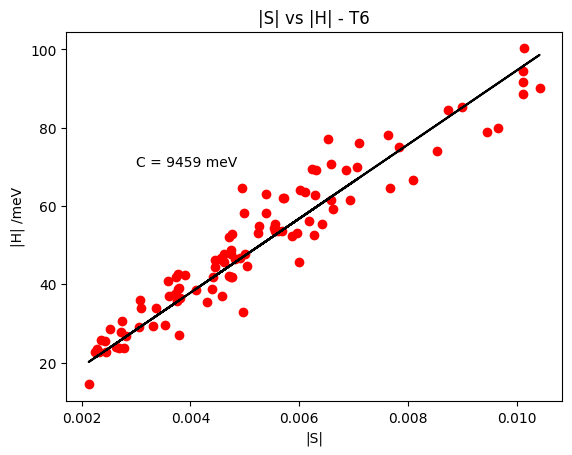

In [21]:
plt.scatter(XSH_T6_array, T6_POD_array, color = 'r')
#plt.axline((0.003,28.377),(0.007,66.213), color = 'k', linestyle = 'dashed')
plt.plot(XSH_T6_array, h_sc(scaling_constant, XSH_T6_array), color='k')
plt.xlabel('|S|')
plt.ylabel('|H| /meV')
plt.title('|S| vs |H| - T6')
plt.text(0.003, 70, 'C = 9459 meV')

Text(0.015, 25, 'C = 9459 meV')

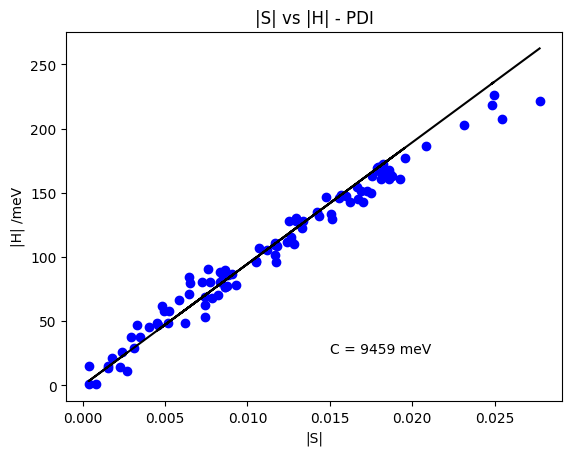

In [22]:
plt.scatter(XSH_PDI_array, PDI_POD_array, color = 'b')
plt.plot(XSH_PDI_array, h_sc(0.347759*27211, XSH_PDI_array), color='k')
plt.xlabel('|S|')
plt.ylabel('|H| /meV')
plt.title('|S| vs |H| - PDI')
plt.text(0.015, 25, 'C = 9459 meV')

Good linear fit for PDI, fit for T6 isn't as good but still an observable correlation. This is expected as T6 exhibits more torsional flexibility which reduces the validity of the assumption that only pi-conjugated orbitals contribute to the FMO. AOM therefore over/underestimates the contribution of each Slater-type orbital to the overlap, because it is only using the component that is perpendicular to the plane of the molecule. If the molecule is non-planar however, you can have non-orthogonal components that now contribute significantly to the FMO.

In [23]:
partial_XSH_T6_array = read_coupling_file('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/run-fssh-noFECT/T6-partial-XSH-coupling.xyz')
partial_XSH_T6_array = partial_XSH_T6_array*27200/scaling_constant

#the partial T6-T6 X-SH coupling array refers to some more coupling vals being removed, since these timesteps'
#geometries cause errors in the pyAOM code, don't know why yet

In [24]:
T6_pyAOM_overlaps = read_coupling_file('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/run-fssh-noFECT/T6-dimer-pyAOM-overlaps.xyz')

#reading in T6-T6 overlaps calculated for dimer geometries at each timestep using pyAOM. We can plot these against
#the X-SH couplings, and we need a near perfect linear relationship with a gradient of 1

Text(0.5, 1.0, 'X-SH vs pyAOM - T6 Dimer')

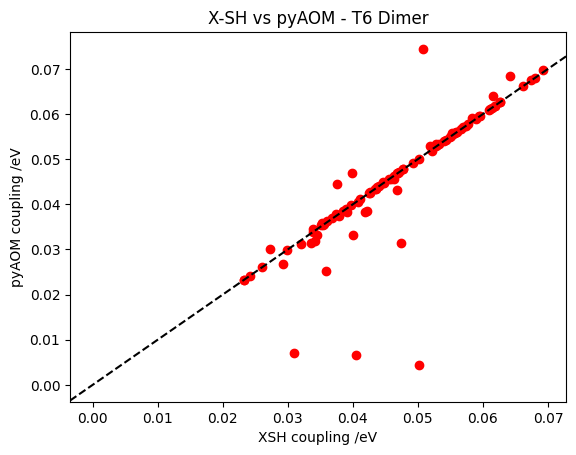

In [25]:
plt.scatter(partial_XSH_T6_array*9.1, T6_pyAOM_overlaps*9.1, color = 'r')
plt.axline((0,0),(0.009,0.009), color = 'k', linestyle = 'dashed')
plt.xlabel('XSH coupling /eV')
plt.ylabel('pyAOM coupling /eV')
plt.title('X-SH vs pyAOM - T6 Dimer')

#plotting a scatter graph of pyAOM and X-SH overlaps

Most overlaps agree very well, but there are a few very large outliers - both for T6 and PDI. The fact that most are in agreement shows that the geometries were correctly sampled, and I double-checked that the ones at the same timestep for pyAOM and X-SH are using the exact same dimer coordinates as inputs. Therefor, we now need to find out where this difference between the two codes is arising. The result of this investigation is laid out in another notebook, in the pyAOM directory in /scratch/Work/X-SH.

In [26]:
T6_pyAOM_regression = sp.linregress(partial_XSH_T6_array, T6_pyAOM_overlaps)
T6_pyAOM_regression.slope

1.0677770137809297

In [27]:
PDI_pyAOM_overlaps = read_coupling_file('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/run-fssh-noFECT/PDI-dimer-pyAOM-overlaps.xyz')
PDI_pyAOM_overlaps = abs(PDI_pyAOM_overlaps)

In [28]:
'''
plt.scatter(XSH_PDI_array*9.1, PDI_pyAOM_overlaps*9.1, color = 'b')
plt.axline((0,0),(0.009,0.009), color = 'k', linestyle = 'dashed')
plt.xlabel('XSH Coupling')
plt.ylabel('pyAOM Coupling')
plt.title('X-SH vs pyAOM - PDI Dimer')
'''

"\nplt.scatter(XSH_PDI_array*9.1, PDI_pyAOM_overlaps*9.1, color = 'b')\nplt.axline((0,0),(0.009,0.009), color = 'k', linestyle = 'dashed')\nplt.xlabel('XSH Coupling')\nplt.ylabel('pyAOM Coupling')\nplt.title('X-SH vs pyAOM - PDI Dimer')\n"

Larger differences in the T6 dimers are expected since the two codes may handle torsional strain differently, but deviations of up to 30% are seen for the more rigid PDI as well, so we will begin our comparison using just the PDI coupling.

In this section I will plot the interfacial X-SH couplings from a 10 ps trajectory of the 3:3 T6:PDI system, against couplings calculated by MS-FED-FCD for the corresponding dimer geometries. I am just reading the X-SH couplings in from the run-pseudo-hamilt.xyz file since I have only done 5 MS-FED-FCD calculations here.  

The order of the dimer files is not the same as their order wrt time in the simulation. Just vimdiff the dimer.txt files with run-pos-1.xyz in the run-fssh-FECT directory to find out the timestep.

The relevant couplings are in the MS-FED-FCD.out files on myriad (currently), the ones I am using refer to the coupling between the first XT and CT-states, which is the top-left element in the first table of values in the file. If you get lost, compare Sam's reported MS-FED-FCD value to his output file in the 'VACUO' directory.

For a better comparison, I then read in 20 more interfacial couplings from X-SH, from a single trajectory. For these couplings' timesteps, I take the interfacial dimer geometry involved in the coupling, and calculate the XT-CT coupling with MS-FED-FCD. I read in the 20 coupling value from MS-FED-FCD as well.

The X-SH couplings are converted into overlaps by dividing them by the scaling constant that was used for that trajectory. The overlaps are plotted against the MS-FED-FCD couplings. Then, I carry out least-squares fitting on a straight line whose y-intercept is constrained on zero, to choose the gradient that best represents the (allegedly linear) relationship between MS-FED-FCD coupling and AOM overlap. It is this gradient which we then use as the new scaling constant for the T6-PDI production runs.

In [29]:
XSH_coupling = np.array([ -0.0012592210, -0.0016527095, -0.0010719015, -0.0007284438, -0.0000237020]) #in hartrees
with open('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/run-fssh-interface/interfacial_couplings.xyz') as XSH_file:
    all_lines = XSH_file.readlines()

    extra_XSH_coupling = list(map(float, all_lines))
    extra_XSH_coupling = np.array(extra_XSH_coupling)

total_XSH_coupling = np.hstack((XSH_coupling, extra_XSH_coupling))
coupling_constant = 0.37759 #hartrees

XSH_overlaps = abs(total_XSH_coupling/coupling_constant)

In [30]:
FED_coupling = np.array([45.8, 83.9, 26.8, 56.34, 30.3])
with open('/scratch/fivanovic/X-SH/T6-PDI/MS-FED-FCD/MSFED_couplings.txt') as MSFED_file:
    all_lines = MSFED_file.readlines()

    extra_FED_coupling = list(map(float, all_lines))
    extra_FED_coupling = np.array(extra_FED_coupling)

extra_FED_coupling = abs(extra_FED_coupling*0.124) #convert wavenumbers to meV
total_FED_coupling = np.hstack((FED_coupling, extra_FED_coupling))

#did this fitting in two chunks. First chunk, I just used 5 coupling values which I just pasted in from the terminal since it was easy.
#The second chunk involved 20 couplings, which I passed into files. I read the values in from the files, then I append these to the arrays 
#containing the first 5 couplings. 

The graph below shows the relative signs of X-SH and MS-FED-FCD couplings. They are opposite in sign but this doesn't matter here, as these are different programs which assign orbital phases differently.

In [31]:
def linear_function(x, gradient):
    return gradient*x

Text(0.5, 1.0, 'MS-FED-FCD Linear Fit')

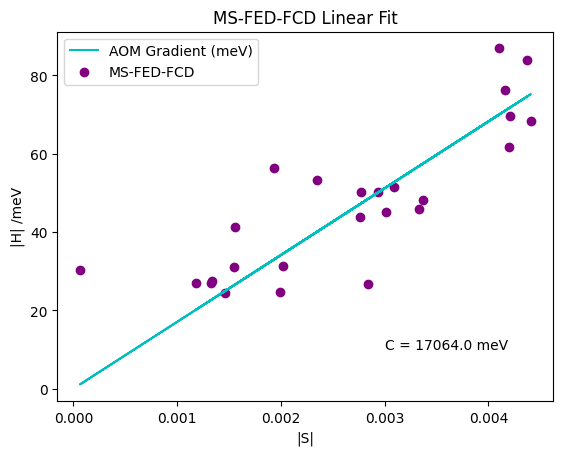

In [32]:
optimised_gradient, extra = curve_fit(linear_function, XSH_overlaps, total_FED_coupling)
#curve fit varies the second argument of the function you pass in, to try and reduce the SSR. The first argument of your target function must
#always be the independent variable which, in this case, is the X-SH overlaps.

optimised_array = optimised_gradient*XSH_overlaps

plt.plot(XSH_overlaps, optimised_array, color = 'c', label = 'AOM Gradient (meV)')
plt.scatter(XSH_overlaps, total_FED_coupling, color = 'purple', label = 'MS-FED-FCD')
plt.legend(loc='upper left')
plt.text(0.003, 10, f'C = {round(optimised_gradient[0], 0)} meV')
plt.ylabel('|H| /meV')
plt.xlabel('|S|')
plt.title('MS-FED-FCD Linear Fit')

Text(0.0025, 7, '$R^{2}_{\\mathrm{XT-CT}}$ = 0.618')

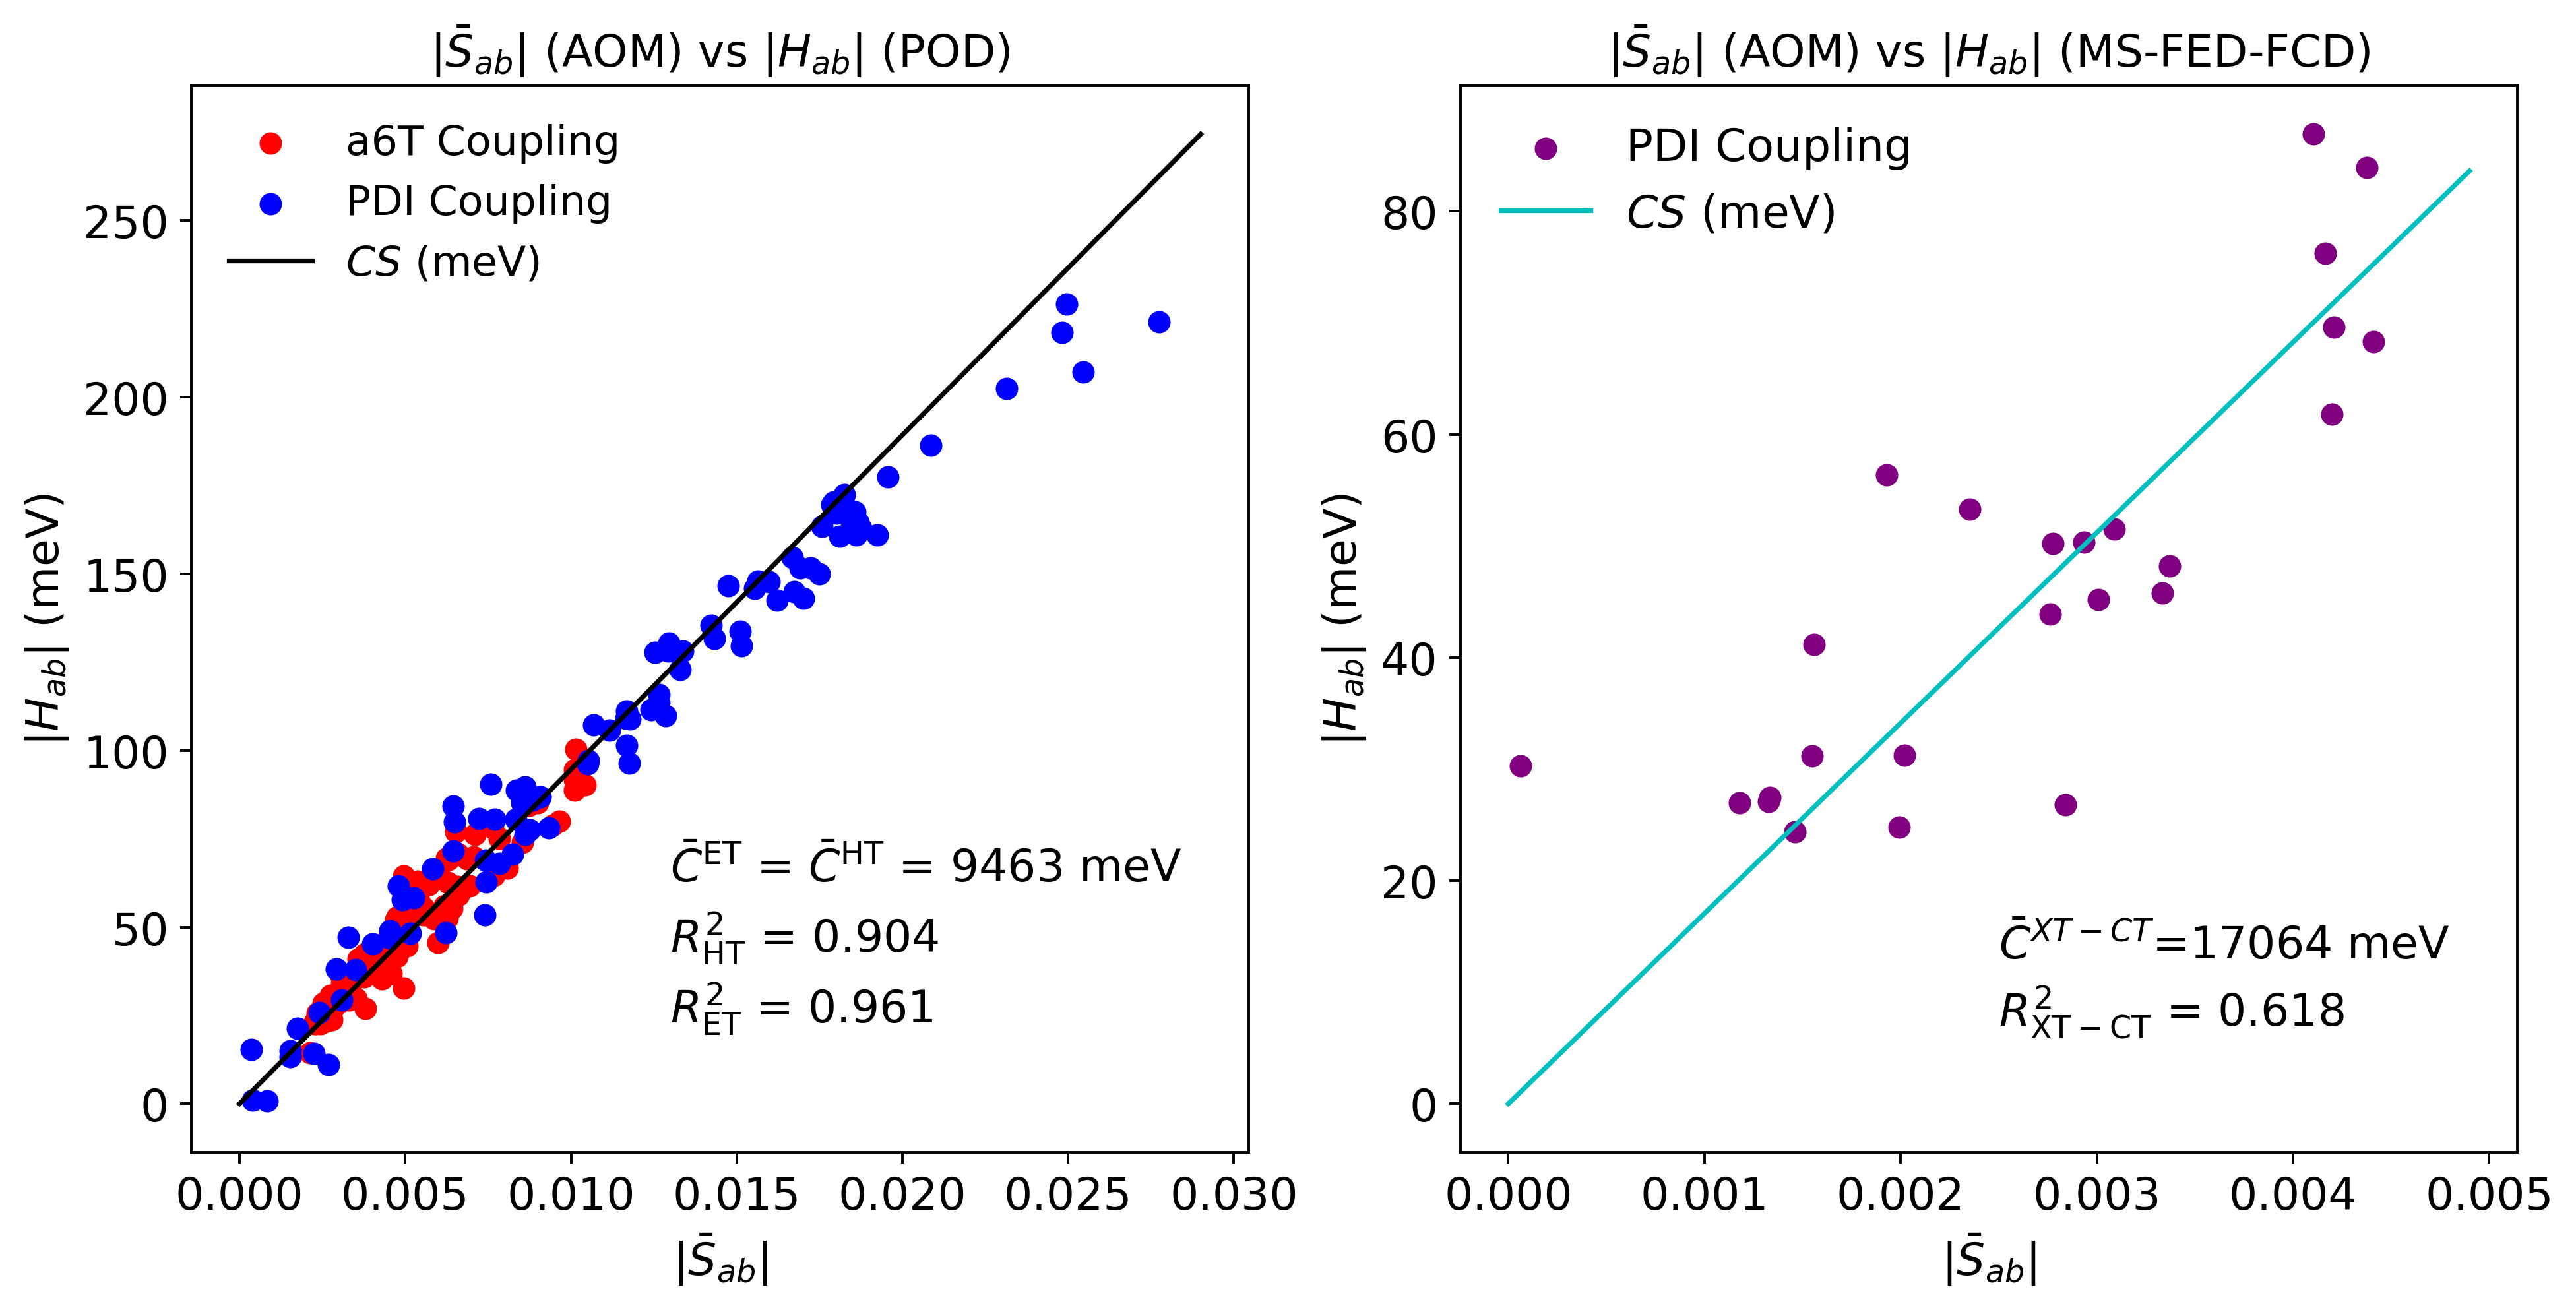

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,6), rasterized=True, dpi=350)

axs[0].scatter(XSH_T6_array, T6_POD_array, color = 'r', label = 'a6T Coupling')
axs[0].scatter(XSH_PDI_array, PDI_POD_array, color = 'b', label = 'PDI Coupling')
axs[0].plot(np.arange(0,0.03,0.001), h_sc(scaling_constant, np.arange(0,0.03,0.001)), color='k', label='$CS$ (meV)')
axs[0].set_xlabel(r'|$\bar{S}_{ab}$|', fontsize=14)
axs[0].set_ylabel('|$H_{ab}$| (meV)', fontsize=14)
axs[0].yaxis.set_tick_params(labelsize = 14)
axs[0].xaxis.set_tick_params(labelsize = 14)
axs[0].set_title(r'|$\bar{S}_{ab}$| (AOM) vs |$H_{ab}$| (POD)', fontsize=14)
axs[0].legend(fontsize=13, frameon=False)
axs[0].text(0.013, 63, r'$\bar{C}^{\mathrm{ET}}$ = $\bar{C}^{\mathrm{HT}}$ = 9463 meV', fontsize=14)
axs[0].text(0.013, 43, r'$R^{2}_{\mathrm{HT}}$ = 0.904', fontsize=14)
axs[0].text(0.013, 23, r'$R^{2}_{\mathrm{ET}}$ = 0.961', fontsize=14)

axs[1].scatter(XSH_overlaps, total_FED_coupling, color = 'purple', label = 'PDI Coupling')
axs[1].plot(np.arange(0,0.005,0.0001), h_sc(optimised_gradient[0], np.arange(0,0.005,0.0001)), color='c', label='$CS$ (meV)')
axs[1].legend(loc='upper left', fontsize=14, frameon=False)
axs[1].set_ylabel('|$H_{ab}$| (meV)', fontsize=14)
axs[1].set_xlabel(r'|$\bar{S}_{ab}$|', fontsize=14)
axs[1].yaxis.set_tick_params(labelsize = 14)
axs[1].xaxis.set_tick_params(labelsize = 14)
axs[1].set_title(r'|$\bar{S}_{ab}$| (AOM) vs |$H_{ab}$| (MS-FED-FCD)', fontsize=14)
axs[1].text(0.0025, 13, r'$\bar{C}^{XT-CT}$' + '=' + f'{round(optimised_gradient[0])} meV', fontsize=14)
axs[1].text(0.0025, 7, r'$R^{2}_{\mathrm{XT-CT}}$ = 0.618', fontsize=14)

Doing the same 'curve_fit' procedure for the linear gradients for T6-T6 and PDI-PDI coupling. They are very similar to the universal constant that Orestis obtained from his fitting to the large dataset they had in the second AOM paper. Therefore, I didn't change the scaling constants for the e-e or h-h couplings for the T6-PDI production runs.

In [34]:
ssq = np.sum((h_sc(scaling_constant, XSH_T6_array) - T6_POD_array)**2)

mean_coupling = np.mean(T6_POD_array)
tss = np.sum((T6_POD_array - mean_coupling)**2)

r2 = 1 - ssq/tss
print(r2)

0.9041034155262478
